In [2]:
pip install xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   - -------------------------------------- 3.7/124.9 MB 20.8 MB/s eta 0:00:06
   ----- ---------------------------------- 16.0/124.9 MB 41.8 MB/s eta 0:00:03
   -------- ------------------------------- 26.7/124.9 MB 44.6 MB/s eta 0:00:03
   ----------- ---------------------------- 36.4/124.9 MB 45.3 MB/s eta 0:00:02
   ---------------- ----------------------- 50.1/124.9 MB 48.4 MB/s eta 0:00:02
   -------------------- ------------------- 64.7/124.9 MB 51.7 MB/s eta 0:00:02
   ------------------------- -------------- 79.2/124.9 MB 53.9 MB/s eta 0:00:01
   ----------------------------- ---------- 91.0/124.9 MB 54.0 MB/s eta 0:00:01
   -------------------------------- ------ 105.1/124.9 MB 55.4 MB/s eta 0:00:01
   ------------------------------------ -- 115.9/124.9 MB 55.1 MB/s eta 0:00:01
   --------------------------------------  124.8/124.9 MB 53.8 MB/s eta 0:00:01
   --------------------------------------  124.8/1


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

In [4]:
# Load and inspect data
df = pd.read_csv("C:/Users/VENKAT VALETI/Downloads/export_1733599585888.csv")
print(df.head())
print(df.info())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2     01-01-2024 00:57      01-01-2024 01:17                1   
1         1     01-01-2024 00:03      01-01-2024 00:09                1   
2         1     01-01-2024 00:17      01-01-2024 00:35                1   
3         1     01-01-2024 00:36      01-01-2024 00:44                1   
4         1     01-01-2024 00:46      01-01-2024 00:52                1   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.72           1                  N           186            79   
1           1.80           1                  N           140           236   
2           4.70           1                  N           236            79   
3           1.40           1                  N            79           211   
4           0.80           1                  N           211           148   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [5]:
# Rename columns for readability
df.rename(columns={
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime'
}, inplace=True)

In [6]:
# Parse datetime columns
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')

In [7]:
# Check if there are any missing values in the dataset
any_missing = df.isnull().values.any()
print(f"Any missing values: {any_missing}")

Any missing values: True


In [8]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

pickup_datetime      9487
dropoff_datetime    10611
dtype: int64


In [9]:
missing_pickup = (9487 / len(df)) * 100
missing_dropoff = (10611 / len(df)) * 100
print(f"Pickup datetime missing: {missing_pickup:.2f}%")
print(f"Dropoff datetime missing: {missing_dropoff:.2f}%")

Pickup datetime missing: 0.90%
Dropoff datetime missing: 1.01%


In [10]:
# Filling missing datetime values with the median of each column
df['pickup_datetime'].fillna(df['pickup_datetime'].median(), inplace=True)
df['dropoff_datetime'].fillna(df['dropoff_datetime'].median(), inplace=True)

C:\Users\VENKAT VALETI\AppData\Local\Temp\ipykernel_24824\3894223761.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pickup_datetime'].fillna(df['pickup_datetime'].median(), inplace=True)
C:\Users\VENKAT VALETI\AppData\Local\Temp\ipykernel_24824\3894223761.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [11]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0]) 

Series([], dtype: int64)


In [12]:
any_missing = df.isnull().values.any()
print(f"Any missing values: {any_missing}")

Any missing values: False


In [13]:
# Feature engineering
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Define target variable: 1 if peak demand, else 0
df['is_peak_demand'] = ((df['pickup_hour'].between(7, 9)) | 
                        (df['pickup_hour'].between(17, 19)) | 
                        (df['is_weekend'] == 1)).astype(int)

In [14]:
# Select features and target
X = df[['PULocationID', 'pickup_hour']]
y = df['is_peak_demand']

# Check unique values in categorical column
print(f"Number of unique pickup locations: {df['PULocationID'].nunique()}")

Number of unique pickup locations: 247


In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# One-hot encode categorical features
encoder = ColumnTransformer(
    transformers=[
        ('pickup_location', OneHotEncoder(handle_unknown='ignore'), ['PULocationID'])
    ],
    remainder='passthrough'
)

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

print(f"Shape of encoded training data: {X_train_encoded.shape}")
print(f"Shape of encoded test data: {X_test_encoded.shape}")


Shape of encoded training data: (734002, 246)
Shape of encoded test data: (314573, 246)


In [16]:
# Initialize and train the XGBoost model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb.fit(X_train_encoded, y_train)

c:\Users\VENKAT VALETI\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [17]:
# Make predictions
y_pred_prob = xgb.predict_proba(X_test_encoded)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.85    158188
           1       1.00      0.63      0.78    156385

    accuracy                           0.82    314573
   macro avg       0.87      0.82      0.81    314573
weighted avg       0.87      0.82      0.81    314573



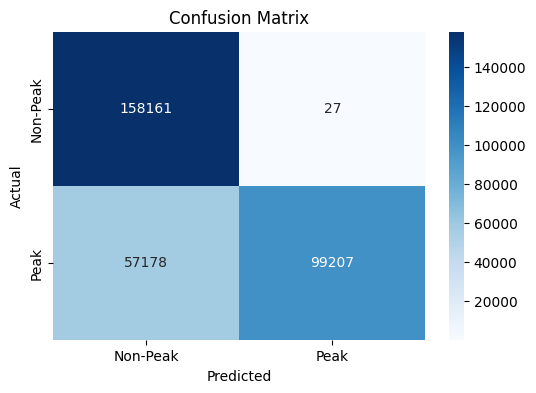

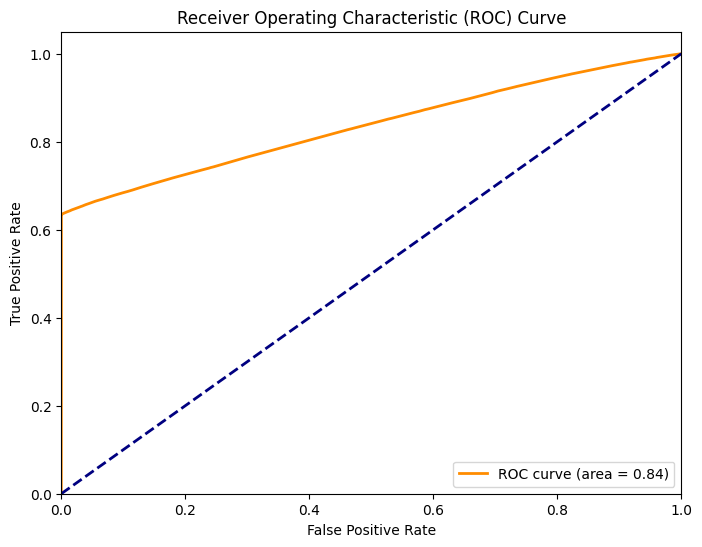

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Peak', 'Peak'], yticklabels=['Non-Peak', 'Peak'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Hypothesis Two

In [19]:
# Feature engineering
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Define target variable based on hypothesis
# Peak demand during:
# Weekdays (7-9 AM, 5-7 PM)
# Weekend nights (Friday and Saturday, 8 PM to 12 AM)
df['is_peak_demand'] = (
    ((df['pickup_hour'].between(7, 9)) & (df['is_weekend'] == 0)) | 
    ((df['pickup_hour'].between(17, 19)) & (df['is_weekend'] == 0)) |
    ((df['pickup_hour'].between(20, 23)) & (df['weekday'].isin([4, 5])))
).astype(int)

print(df['is_peak_demand'].value_counts())

# Select features: hour, weekday, and whether it's a weekend
X = df[['pickup_hour', 'weekday', 'is_weekend']]
y = df['is_peak_demand']

is_peak_demand
0    750928
1    297647
Name: count, dtype: int64


In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the XGBoost model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb.fit(X_train, y_train)

# Make predictions
y_pred_prob = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)


c:\Users\VENKAT VALETI\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [21]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    225279
           1       1.00      1.00      1.00     89294

    accuracy                           1.00    314573
   macro avg       1.00      1.00      1.00    314573
weighted avg       1.00      1.00      1.00    314573



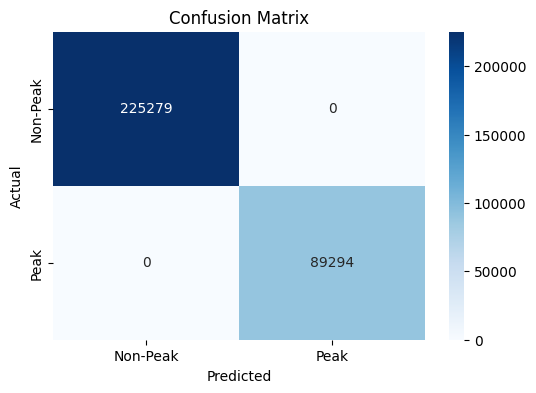

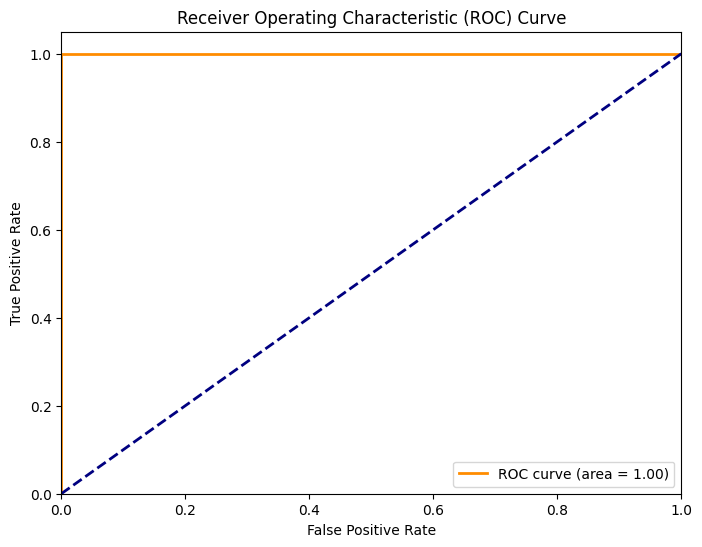

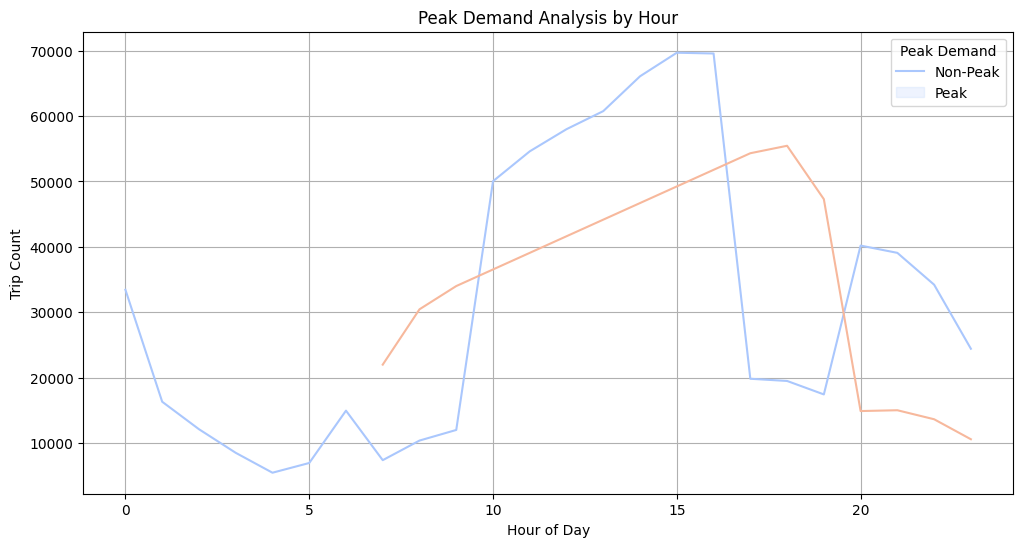

In [22]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Peak', 'Peak'], yticklabels=['Non-Peak', 'Peak'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Aggregate demand by hour
hourly_demand = df.groupby(['pickup_hour', 'is_peak_demand']).size().reset_index(name='trip_count')

# Plot demand by hour
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_demand, x='pickup_hour', y='trip_count', hue='is_peak_demand', palette='coolwarm')
plt.title('Peak Demand Analysis by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Count')
plt.legend(title='Peak Demand', labels=['Non-Peak', 'Peak'])
plt.grid()
plt.show()

Number of rides on Friday evenings (8 PM to 12 AM): 35560
Number of rides on other days (8 PM to 12 AM): 156490


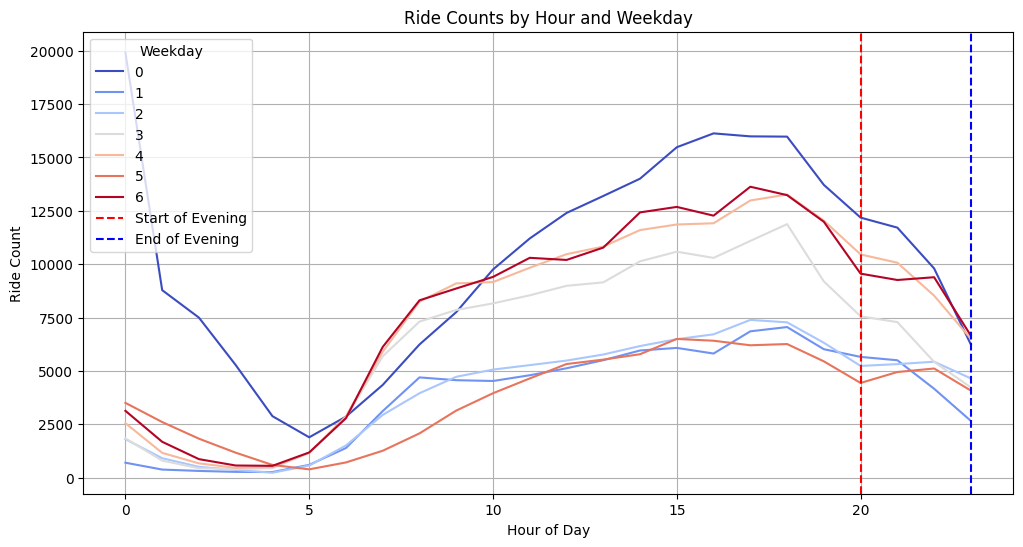

C:\Users\VENKAT VALETI\AppData\Local\Temp\ipykernel_24824\3056122925.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=evening_rides, x='weekday', y='ride_count', palette='viridis')


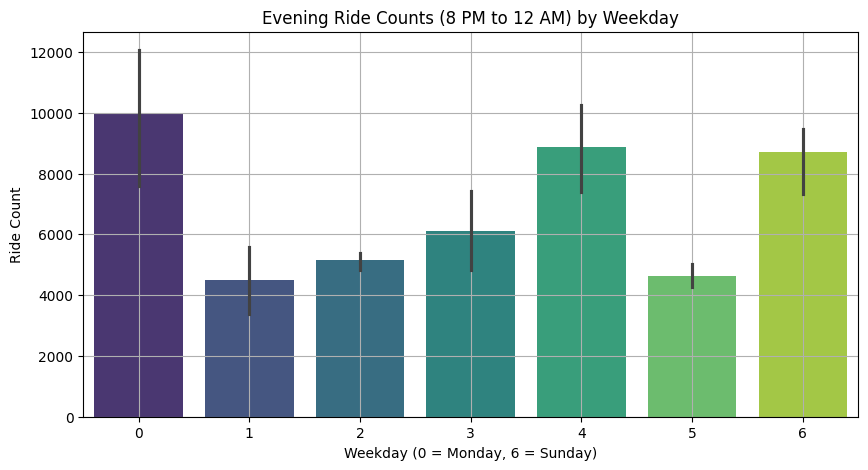

In [24]:
# Filter for Friday evenings (8 PM to 12 AM)
friday_evenings = df[(df['weekday'] == 4) & (df['pickup_hour'].between(20, 23))]

# Count the number of rides on Friday evenings
friday_evenings_count = friday_evenings.shape[0]
print(f"Number of rides on Friday evenings (8 PM to 12 AM): {friday_evenings_count}")

# Compare with other days at the same time range
other_days_evenings = df[(df['weekday'] != 4) & (df['pickup_hour'].between(20, 23))]
other_days_evenings_count = other_days_evenings.shape[0]
print(f"Number of rides on other days (8 PM to 12 AM): {other_days_evenings_count}")

# Aggregate by weekday and hour for better insights
weekday_hourly = df.groupby(['weekday', 'pickup_hour']).size().reset_index(name='ride_count')

# Visualize Friday evening rides vs. other days
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekday_hourly, x='pickup_hour', y='ride_count', hue='weekday', palette='coolwarm')
plt.axvline(20, color='red', linestyle='--', label='Start of Evening')
plt.axvline(23, color='blue', linestyle='--', label='End of Evening')
plt.title('Ride Counts by Hour and Weekday')
plt.xlabel('Hour of Day')
plt.ylabel('Ride Count')
plt.legend(title='Weekday', loc='upper left')
plt.grid()
plt.show()

# Focus only on evenings (8 PM to 12 AM) to see weekday trends
evening_rides = weekday_hourly[weekday_hourly['pickup_hour'].between(20, 23)]
plt.figure(figsize=(10, 5))
sns.barplot(data=evening_rides, x='weekday', y='ride_count', palette='viridis')
plt.title('Evening Ride Counts (8 PM to 12 AM) by Weekday')
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)')
plt.ylabel('Ride Count')
plt.grid()
plt.show()


In [1]:
total_evening_rides = friday_evenings_count + other_days_evenings_count
friday_percentage = (friday_evenings_count / total_evening_rides) * 100
print(f"Percentage of evening rides on Friday: {friday_percentage:.2f}%")


NameError: name 'friday_evenings_count' is not defined